# Spark ML

Rémi Pépin, Arthur Katossky, Ludovic Deneuville

## Before you start

-   [ ] Download this
    <a href="lab2.ipynb" target="_blank">Jupyter Notebook</a>
-   [ ] Follow these
    <a href="../lab-setup.qmd" target="_blank">instructions</a>

💡 If your Jupyter is in dark mode, some images may not display
properly. You can switch to light mode in Settings \> search for theme
\> Selected Theme: JupyterLab Light

## Outline

In this tutorial, we are going to perform exploratory and explanatory
analyses of a massive dataset consisting in hundreds of thousands of
AirBnB listings, as made available by the Inside
<a href="http://insideairbnb.com/get-the-data.html" class="external"
target="_blank">AirBnB project</a>.

You will find these listings at this address:

-   `s3://ensai-labs-2023-2024-files/lab2/airbnb/` on AWS
-   `s3a://ludo2ne/diffusion/ensai/airbnb/` on SSPCloud

## 1 Create a Spark session

-   [ ] Depending on the **chosen platform**, initialize the Spark
    session

### 1.1 Only on SSPCloud

See default configuration on the datalab :

In [1]:
! cat /opt/spark/conf/spark-defaults.conf

To modify the config :

In [2]:
import os
from pyspark.sql import SparkSession

spark = (SparkSession
         .builder
         # default url of the internally accessed Kubernetes API
         # (This Jupyter notebook service is itself a Kubernetes Pod)
         .master("k8s://https://kubernetes.default.svc:443")
         # Executors spark docker image: for simplicity reasons, this jupyter notebook is reused
         .config("spark.kubernetes.container.image", os.environ['IMAGE_NAME'])
         # Name of the Kubernetes namespace
         .config("spark.kubernetes.namespace", os.environ['KUBERNETES_NAMESPACE'])
         # Allocated memory to the JVM
         # Stay careful, by default, the Kubernetes pods has a higher limit which depends on other parameters.
         .config("spark.executor.memory", "4g")
         .config("spark.kubernetes.driver.pod.name", os.environ['KUBERNETES_POD_NAME'])
         # dynamic allocation configuration
         .config("spark.dynamicAllocation.enabled","true")
         .config("spark.dynamicAllocation.initialExecutors","1")
         .config("spark.dynamicAllocation.minExecutors","1")
         .config("spark.dynamicAllocation.maxExecutors","5")
         .getOrCreate()
        )

In [3]:
# See the current number of executors (one for now)
!kubectl get pods -l spark-role=executor

### 1.2 Only on AWS

In [4]:
#Spark session
spark

# Configuraion
spark._jsc.hadoopConfiguration().set("fs.s3.useRequesterPaysHeader","true")

### 1.3 Check spark session

In [5]:
spark

## 2 How to distribute elementary statistical tasks?

**The map and reduce principle**

When your data is distributed, i.e is spread out across multiple hard
disks / memories on different logical or physical machines, it is
clearly not possible to load everything in memory to perform some
computation. (No computer from the cluster would have enough storage
space / memory space to load the full data set, and the exchange of
information *between* the nodes of the cluster would take considerable
amounts of time.) What can you do then?

A surprisingly satisfying situation is when your algorithm can be
expressed in a `map-and-reduce model`. A `map` step, in computer
science, is the equivalent a function in mathematics: from a given
entry, return an output. Examples include counting the number of
occurrences of a word in a text, squaring some number, subtracting some
number, etc. A `reduce` step takes two inputs and produces one input,
and can be called recursively onto its own outputs, progressively
yielding the final result through a pyramid of `accumulators` (see
diagram here under). Popular reduce functions include (pairwise)
concatenation of character strings, (pairwise) product, (pairwise)
minimum and (pairwise) maximum. But `pairwise addition` is probably the
most used reduce function, with the aim goal of performing a complete
addition:

Hadoop’s MapReduce is the name of what was to become today Apache Spark.
The persons behind this framework were among the first to advocate for
the map-and-reduce mode in order to achieve efficient parallelisation.
Unfortunately, the similarity of the names causes a lot of confusion
between the map-and-reduce theoretical model and the concrete Hadoop
implementation. I will use “map-and-reduce” to help distinguish the
algorithmic concept from the MapReduce program, but this is *not*
standard in the literature.

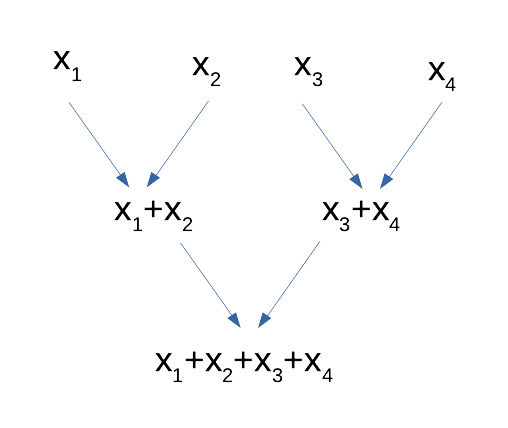

**Why is the map-and-reduce scheme so interesting?**

Well, say you have $n$ entries and $k$ worker nodes at your disposal.
The map operation can always be performed locally on each node, since
the transformation does not depend on the rest of the data set. This is
an **embarrassingly parallel problem** and we roughly divide the
execution time by $k$. Then, most of the reduce steps can also happen on
the worker nodes, until the local data has been completely summarized.
This also an $k$\_fold acceleration! Then, there remains only $k$ reduce
steps, and since $k \ll n$, this is usually quite negligible, even
though the (potentially high) networking costs happen at this step.
There is still some cost of task coordination and data exchange, but
this usually small compared to the costs of parallelisation.

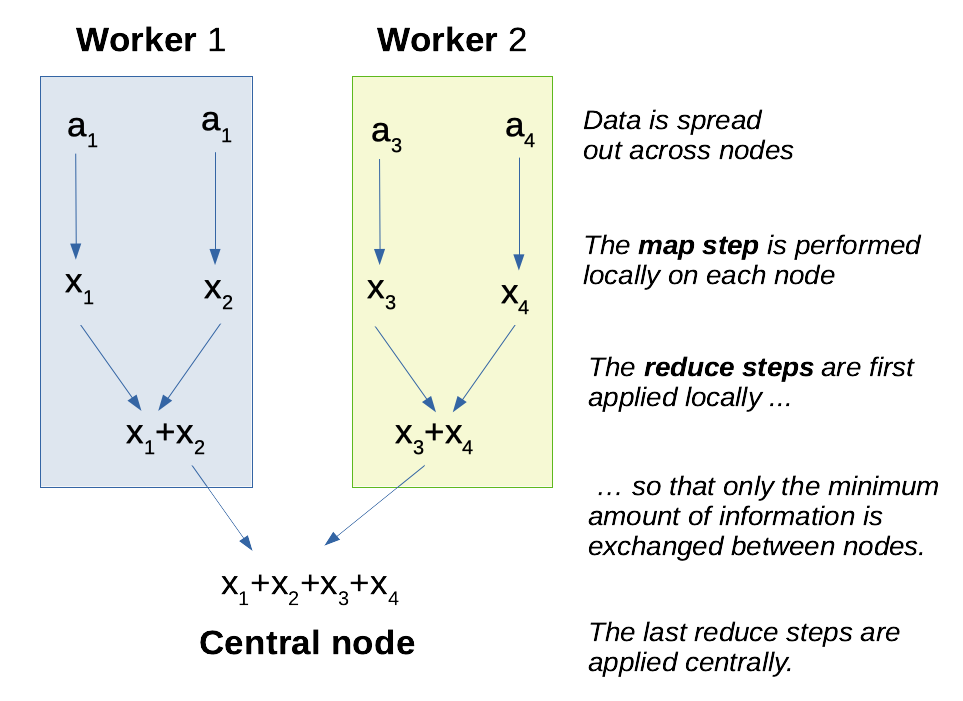

**The reduce step**

**A reduce function is an associative function**
$f: E \times E \mapsto E$, where associativity means
$\forall (a,b,c) \in E^3, f(a,f(b,c))=f(f(a,b),c)$. This is required
because the distribution of data blocks across the nodes is random, and
that we want to minimize data transmission between the nodes.

Moreover, **$f$ may or may not be commutative**, in the sense that
$f(a,b)=f(b,a)$. If it is the case, such as with addition and
multiplication, then the computing may happen in no particular order.
This means that the central node need not wait for some partial results
to be returned by a belated node. On the contrary, if $f$ is not
commutative, (a) the worker nodes must apply the function in a defined
order, (b) the central node needs to reduce the intermediate outputs in
a defined order, (c) it may have to delay the final reduce steps because
of a lingering node.

The reduce function must not be defined on $E=\mathbb{R}$. For instance,
in the context where data is a collection of text documents, a
word-count function may return accumulator objects looking like:
`((word1,count1), (word2,count2))`. Also, the accumulators — that is,
the outputs of the each intermediate reduce step — are not necessarily
exactly the cumulative version of the final statistic our algorithm
outputs! Rather, **accumulators are information-dense, fast-to-compute
summary statistics** from which the required final statistics can be
obtained.

Imagine you want to count the frequency of the vocal E in English, given
a collection of texts. It is faster to count the number of Es as well as
the total number of characters than to accumulate directly the
frequencies, as shown in this diagram:

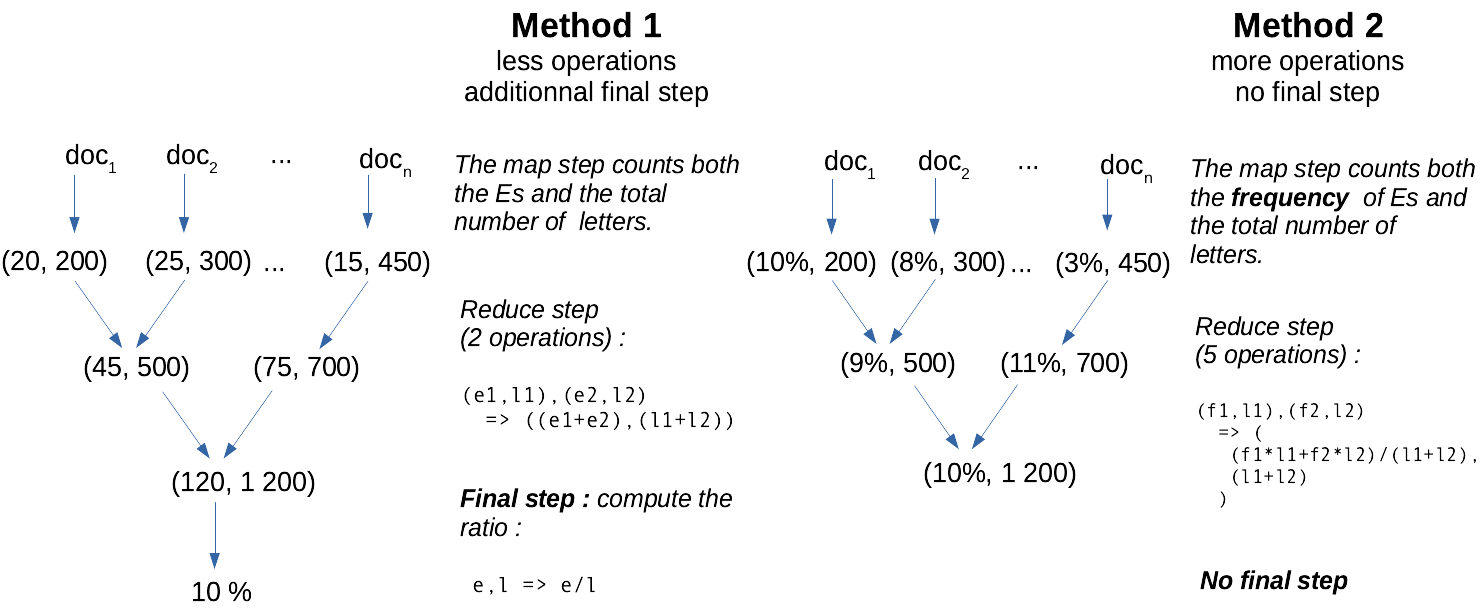

**Online algorithms**

An **online algorithm** is an algorithm with an inner state that can be
actualized at low cost for any new arrival of data. A good metaphor is
track-keeping of the number of people on a bus: every time a person
enters or leaves, you apply ±1 to the count, without the need to
systematically recount everyone. Said otherwise, an online algorithm is
any algorithm whose last result can be actualized from new data, at a
smaller cost than an alternative algorithm that uses both old and new
data from scratch.

It turns out that **respecting the map-and-reduce model gives us online
algorithms for free**, where the **inner state** of the algorithm is the
output from the last reduce call. Indeed, writing $s_\text{old}$ and
$s_\text{new}$ the old and new states (the old and new summary
statistics), and $x_{new}$ the latest data point, we have:

$$s_\text{new}=\text{reduce}(s_\text{old}, \text{map}(x_\text{new}))$$

Thus, writing an algorithm following the map-and-reduce model gives you
both a parallelized batch algorithm and a stream algorithm at once.

**Number of passes**

So far we have discussed algorithms that require only one map and one
reduce functions. But for some statistics, it is not sufficient. For
instance, if we want to count the number of texts where the letter E is
more common than average, we first have to compute the average frequency
in a first pass, then to count the texts where the frequency exceed this
number with a second one. We can NOT do this in only one run, since the
global average frequency is not known !

Each run is called a **pass** and some algorithms require several
passes.

**Limits**

-   Not all statistical algorithms can be expressed according to the
    map-and-reduce algorithm, and when they can, it may require a
    significant re-writing compared to the standard algorithms.
-   There may be a trade-off between the number of passes, the speed of
    each map / reduce steps and the volume of data transferred between
    each reduce step.

### 2.1 ✍ Hands-on 1

-   You are given `errors`, a distributed vector of prediction errors
    `errors = [1, 2, 5, 10, 3, 4, 6, 8, 9]`
-   [ ] Write a map-and-reduce algorithm for computing the **total sum
    of squares**.
    -   You may want to create a Python version of this algorithm, using
        the `map(function, vector)` and `reduce(function, vector)`
        functions or you may use lambda-functions
    -   You have to import `reduce` from the `functools` module

In [6]:
# Code Here

-   [ ] Write **two** different map-and-reduce algorithm for computing
    the ***mean* sum of squares**. *(One may include a final $O(1)$
    step.)*

In [7]:
# Code Here

-   [ ] Is the median easy to write as a map-and-reduce algorithm? Why?

In [8]:
# Code Here

-   [ ] Given a (distributed) series of numbers, the variance can be
    straightforwardly expressed as a two-pass algorithm: (a) in a first
    pass, compute the mean, then (b) in a second pass, compute the mean
    of the errors to the mean. Can it be expressed as a one-pass only
    algorithm? Is it more expensive to compute variance *and* mean
    instead of the variance alone?

In [9]:
# Code Here

## 3 Application on Airbnb Data

In [10]:
from pyspark.sql.types import FloatType, IntegerType, DateType
from pyspark.sql.functions import regexp_replace, col

# Uncomment one of the following lines
# listings_raw = spark.read.csv("s3a://ludo2ne/diffusion/ensai/airbnb/", header=True, multiLine=True, escape='"') # or listings_raw = spark.read.parquet("s3a://ludo2ne/diffusion/ensai/airbnb.parquet")
# listings_raw = spark.read.csv("s3://ensai-labs-2023-2024-files/lab2/airbnb/", header=True, multiLine=True, escape='"')

In [11]:
listings = (listings_raw
  .withColumn("beds",     listings_raw["beds"    ].cast(IntegerType()))
  .withColumn("bedrooms", listings_raw["bedrooms"].cast(IntegerType()))
  .withColumn("time", listings_raw["last_scraped"].cast(DateType()))
  .withColumn("price", regexp_replace('price', '[$\\,]', '').cast(FloatType()))
  .select("id", "beds", "bedrooms", "price", "city", "time")
  .dropna() # remove lines with missing values
)

In [12]:
listings_raw.cache()
listings.cache()

### 3.1 ✍ Hands-on 2

-   [ ] How many lines do the raw and the formatted datasets have?

In [13]:
# Code Here

-   [ ] How many columns are there?
    -   [ ] Can you list all the available columns?

In [14]:
# Code Here

**Spark SQL’s `summary()` method**

In Spark SQL, **elementary univariate summary statistics can also be
obtained through the `summary()` method**. The `summary()` method takes
either the names of the statistics to compute, or nothing, in which case
it computes every possible statistics:

``` python
listings.summary("count", "min", "max").show() # computes the selection of statistics
```

``` python
listings.summary().show() # computes every possible statistics
```

This is a way to incite you to compute all the statistics you want at
the same moment : it avoids an extra pass on the data set because all
accumulators can be computed simultaneously. You can fin a list of all
supported statistics <a
href="https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.html"
class="external" target="_blank">here</a> in PySpark documentation:
count, mean, standard-deviation, minimum, maximum, approximate median,
approximate first and last quartiles. Null (missing) values will be
ignored in numerical columns before calculation.

**Spark ML**

Spark ML is a Spark module that allow us to execute parallelised
versions of most popular machine-learning algorithms, such as linear or
logistic regression. However, we can also use Spark ML to compute
elementaty univariate summary statistics. However the philosophy is
quite different, and is worth explaining.

The syntax of Spark ML may feel artificially convoluted ; this not only
an impression, it *is* convoluted. However, there are grounds for this
situation :

1.  Spark ML has been built on top of Spark years into the project, and
    the core of Spark is not well adapted to machine-learning ;
2.  Spark ML is intended for much more advanced treatments than
    unviariate statistics, and we will see linear regression as an
    exemple at the end of this tutorial

**Step 1: vectorisation.** A little counter-intuitively, spark ML
operates on a single column of your data frame, typically called
`features`. (Features is the word used in the machine-learning community
for “variables”, see “Vocabulary” section hereunder.) This `features`
column has the `Vector` type: each element contains an array of
floating-point numbers, representing a subst of the variables from your
dataset. The key is that this `features` column is usually redundant
with the rest of the data frame: it just ensures the proper conversion
from any type we wish (string, integer…) to a standardized numeric
format. Indeed, it is often derived from the other columns, as this
image illustrates:

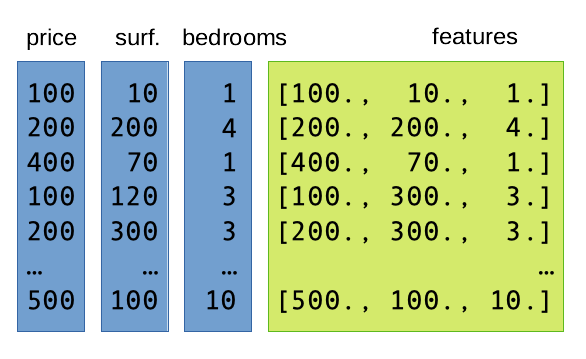

Unfortunately for us, the construction the `features` column is not
performed automatically under the hood by Spark, like when doing
statistics in R. On the contrary, we have to construct the column
explicitly. The `VectorAssembler()` constructor is here for that:

``` python
from pyspark.ml.feature import VectorAssembler

vectorizer = VectorAssembler(
    inputCols     = ["price", "beds", "bedrooms"], # the columns we want to put in the features column
    outputCol     = "features",                    # the name of the column ("features")
    handleInvalid = 'skip'                         # skip rows with missing / invalid values
)

listings_vec = vectorizer.transform(listings)

# Reminders:
# Spark data sets are immutable: a copy is returned, and the original is unchanged.
# Spark operations are lazy: listings_vec just contains the recipe for building vector column
# but no item of the column is computed unless explicitly asked to.

listings_vec.show(5) # The first 5 values of the features column are computed.
```

**Step 2: summarization.** Now that we have a vector column, we can use
a `Summarizer` object to declare all the statistics we want to compute,
in a similar fashion than with the Spark SQL `summary()` method. The
following statistics are known: mean\*, sum\*, variance\*,
standard-deviation\*, count\*, number of non-zero entries, maximum\*,
minimum\*, L2-norm, L1-norm, as can be read in <a
href="https://spark.apache.org/docs/3.1.1/api/python/reference/api/pyspark.ml.stat.Summarizer.html"
class="external" target="_blank">the documentation</a>. *(Stars (\*)
denote statistics that could also be computed with the `summary()`
method. Approximate quartiles are not computed.)* Summarizers are
created with the `Summarizer.metrics()` constructor. Here again, you are
incited to declare all the summaries at once, so that they can all be
computed in one pass:

``` python
from pyspark.ml.stat    import Summarizer

summarizer = Summarizer.metrics("count", "min", "max")

listings_vec.select( summarizer.summary(listings_vec.features), ).show(truncate=False)
# By default, the output of columns is capped to a maximum width.
# truncate=False prevents this behaviour.
```

This produces the output:

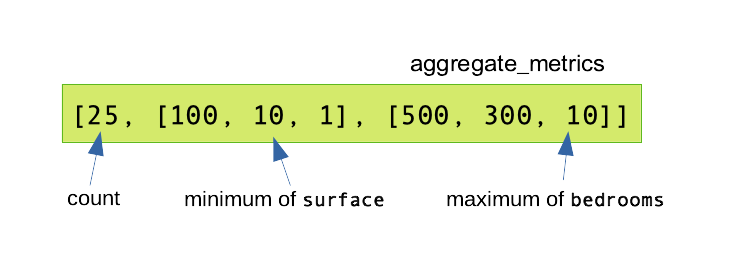

### 3.2 ✍ Hands-on 3

-   [ ] Is `listings.summary()` slower to run than
    `listings.summary("count", "min", "max")` ? Why?
    -   You can measure time in Python with this simple template:

    ``` python
    from timeit import default_timer as t
    start = t()
    # the thing you want to measure
    print("Time:", t()-start)
    ```

In [15]:
# Code Here

In [16]:
# Code Here

-   [ ] Compute the average number of beds per property in Barcelona in
    four different ways:
    -   Which method is the fastest?
        1.  directly with the Spark SQL mean function,
        2.  using `summary()`,
        3.  using a `Sumarizer` object
        4.  locally after you collected the bed columns. *Despite the
            operation being very common, Spark does **not** provide a
            simple syntax to collect a column as a local array. A
            work-around is to use the Pandas package and the `asPanda()`
            method (<a
            href="https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.DataFrame.toPandas.html"
            class="external" target="_blank">documentation</a>). First
            install Pandas with `!pip install pandas`. Then you can
            collect a local copy of a dataframe called `df` with:
            `df_local = df.toPandas()`. A Pandas data frame possesses a
            `mean()` method, that compute the mean of each column of the
            data frame: more details are in Pandas’ <a
            href="https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html"
            class="external" target="_blank">documentation</a>.*

In [17]:
# Spark SQL mean function

In [18]:
# summary()

In [19]:
# Sumarizer

In [20]:
# locally after you collected the bed columns

# !pip install pandas

The most simple model is often surprisingly difficult to beat!

-   [ ] Compute the mean price on the data set as a predictor for an
    AirBnB listing’s price and the total sum of squares. (We will
    elaborate in the next section.)

In [21]:
# Code here

## 4 Regression with Spark ML

A better way to predict prices is to build a regression mode, which in
Spark falls under the broad category of machine-learning problems.
Regressions thus belong the the `ml` module, often called Spark ML, like
the summarizer that we saw just before.

There is an old module called `mllib` that is also called “Spark ML”.
That can cause confusion.

The `ml` module is built in a distinctive fashion than the rest of
Spark. **Firstly** we have seen with `Summarizer` that we can not
readily use the columns and that instead **columns have to be first
converted to a `Vector` format** with the `VectorAssembler` function.

**Secondly**, we need to distinguish between two different types of
object classes: transformers and estimators classes. **Transformers**
are a class of objects representing any process that modifies the
dataset, and returns the modified version. It has a **transform()**
method. **Estimators** on the other hand are classes of objects
representing any process that produces a transformer based on some
computed parameters from the data set. It has a **`fit()`** method. It
is easier with an example. In the following example, `regressor` is an
estimator, and we compute the regression coefficients with the `fit()`
method. This produces `model`, the regression model itself, which is of
class transformer. Indeed, we can use its `transform()` method to add
predictions to the initial dataset.

``` python
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

vectorizer = VectorAssembler( # copy-pasted from previous section...
    inputCols     = ["beds", "bedrooms"], # ... but without price
    outputCol     = "features",
    handleInvalid = 'skip'
)

listings_vec = vectorizer.transform(listings)

regressor = LinearRegression(featuresCol="features", labelCol="price")
model     = regressor.fit(listings_vec)

model.coefficients
model.intercept

listings_pred = model.transform(listings_vec)
listings_pred.show() # model and predictions from the regression
```

**Vocabulary**

The machine-learning community leaves at the border between computer
science and mathematics. They borrow vocabulary from both sides, and it
can sometimes be confusing when reading software documentation. Spark’s
`lib` module uses conventions from this community :

-   **label**, rather than “independent variable”. This comes from the
    fact that historically, machine-learning has originated from
    problems such as image labeling (for instance digit recognition).
    Even for continuous variables, machine-learners may use “label”
-   **features**, rather than “dependent variables” ; the number of
    features is often dubbed $d$ like dimension (instead of $p$ in
    statistics)
-   machine-learners don’t use the word “observation” or “unit” and
    prefer **row**

**Pipelines**

If you come to repeat several times the same series of transformations,
you may take advantage of the pipeline objects. A **pipeline** is just a
collections of steps applied to the same dataset. This helpful when you:

-   repeat the same analysis for different regions / periods
-   want to control predictions on a new, unseen test set, and ant to
    apply exactly the same process

``` python
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline

vectorizer = VectorAssembler( # same vectorizer as before
    inputCols     = ["beds", "bedrooms"],
    outputCol     = "features",
    handleInvalid = 'skip'
)
regressor = LinearRegression(featuresCol="features", labelCol="price") # same regressor
pipeline  = Pipeline(stages = [vectorizer, regressor]) # ... but now we pack them into a pipeline

listings_beij = listings.filter(listings.city=="Beijing")
listings_barc = listings.filter(listings.city=="Barcelona")

model_beij = pipeline.fit(listings_beij) # vectorizer AND regressor are applied
model_barc = pipeline.fit(listings_barc)

print(model_beij.stages[1].coefficients) # model.stages[0] is the first step, model.stages[1] the second...
print(model_beij.stages[1].intercept)

print(model_barc.stages[1].coefficients)
print(model_barc.stages[1].intercept)
```

### 4.1 ✍ Hands-on 4

-   [ ] Interpret the results of the general regression.

In [22]:
# Code here

-   [ ] Collect the model’s $R^2$. How good is our model?
    -   Models have a `summary` property, that you can explore with
        `dir(model.summary)`.

In [23]:
# Code here

-   [ ] Repeat the estimation separately for barcelona, brussels and
    rome.
    -   [ ] Are the coefficients stable? *You will build a pipeline
        object.*

In [24]:
# Code here

-   [ ] Are the `fit()` and `transform()` methods called eagerly or
    lazily?
    -   [ ] Check the execution plan with the `explain()` method for
        lazy evaluations.

In [25]:
# Code here

## 5 Diving deeper

You are in autonomy for this section. You will find helpful:

-   <a href="https://spark.apache.org/docs/latest/ml-guide.html"
    class="external" target="_blank">The general Spark documentation for the
    <code>ml</code> module</a>
-   <a href="https://spark.apache.org/docs/latest/api/python/index.html"
    class="external" target="_blank">The PySpark documentation</a>

### 5.1 ✍ Hands-on 5

-   [ ] Add a categorical variable to the regression.

In [26]:
# Code here

-   [ ] Compute the p-values of your model as well as confidence
    intervals for the predictions.

In [27]:
# Code here

-   [ ] Time the regression in different settings and report the results
    on [this shared
    spreadsheet](https://docs.google.com/spreadsheets/d/1KSCLMgiepoKKiDdRrwlQv_0XYn5ptzXRB7TP-TRXCAw/edit?usp=sharing).
    How does it scale with the number of listings ($n$) ? the number of
    regressors ($p$) ? the number of nodes in your cluster ($k$) ? *You
    will only try a couple of configurations that have not been tested
    by others. Remember that you can order and revoke nodes from your
    cluster at any time from the AWS’s cluster view, in the hardware
    tab, on on the CORE line, “resize”.*

In [28]:
# Code here

-   [ ] Down-sample your data set to $n=100000$, while still keeping a
    few variables. Save it on S3, then download it on your computer. Run
    the regression locally on your computer in R. In your opinion, is
    the extra precision (in term of $R^2$) is worth the extra
    computation time?

In [29]:
# Code here

## End of the Lab

-   [ ] Export your notebook
    -   Right click and Download (.ipynb)
    -   File \> Save and Export Notebook \> HTML

### SSPCloud

-   [ ] Delete the Jupyter-pyspark service
    -   <a href="https://datalab.sspcloud.fr/my-services"
        target="_blank">SSPCloud &gt; My services &gt; Delete</a>

### AWS

-   [ ] Terminate your cluster
    -   On *EMR* service page, click on *Clusters*
    -   Select the active cluster and click on `Terminate`

> **Solution**
>
> <a href="lab2-correction.qmd" target="_blank">Solution</a>